In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

# SILAC Experiments

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [4]:
#get glycosome data
ref_df = pd.read_csv('out_data/glycosome_experiment_extended.txt',sep='\t')    
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('out_data/glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())


ref_df = ref_df.join(lucia_experiments,how='left')
ref_df.drop_duplicates(subset=['[Gene ID]'],inplace=True)
ref_df.set_index('[Gene ID]',inplace=True,drop=True)
ref_df=ref_df[['Log2 H/L','Log10 (Int H*L)','Group', 'Glycosome status ']]
ref_df.head()

Log2 H/L  Log10 (Int H*L) Group Glycosome status 
[Gene ID]                                                      
Tb06.3A7.270 -0.113504        11.743189     i               red
Tb927.9.1350  0.020373        13.847976     i               red
Tb927.9.1360  0.034075        11.430029     i               red
Tb927.9.1380  0.158678        12.763610     i               red
Tb927.9.1410  0.002214        13.992089     i               red

# Experiment 1
## bait Tb927.11.12080

In [14]:
#read data and log transform for plots
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df.head()

df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]


df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  

df['logInt']=np.log10(df['Intensity'])
df['logRatio']=np.log2(df['Ratio H/L normalized'])
df['logScore']=np.log10(df['Score'])
df.head()

removed  52 Only identified by site
tot  52  entries removed
---------------
removed  20 Reverse
tot  72  entries removed
---------------
removed  29 Potential contaminant
tot  101  entries removed
---------------


Protein IDs  \
58  Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...   
59          Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1   
60          Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1   
61          Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1   
62           Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1   

                                 Majority protein IDs Peptide counts (all)  \
58  Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...              10;10;5   
59          Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1                  1;1   
60          Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1                  2;2   
61          Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1                  1;1   
62           Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1                  2;2   

   Peptide counts (razor+unique) Peptide counts (unique) Fasta headers  \
58                       10;10;5                 10;10;5            ;;   
59                           1;1                     1;1             ;   
60                           2;2                     2;2             ;   
61                           1;1                     1;1             ;   
62                           2;2                     2;2             ;   

    Number of proteins  Peptides  Razor + unique peptides  Unique peptides  \
58                   3        10                       10               10   
59                   2         1                        1                1   
60                   2         2                        2                2   
61                   2         1                        1                1   
62                   2         2                        2                2   

      ...                                            Best MS/MS  \
58    ...     584;2679;3663;4909;5238;5244;9265;10971;15238;...   
59    ...                                                  2821   
60    ...                                            7603;15454   
61    ...                                                 16138   
62    ...                                            9397;12919   

    Oxidation (M) site IDs  Oxidation (M) site positions       Gene_id  \
58                     NaN                           NaN  Tb927.5.4460   
59                     NaN                           NaN  Tb927.5.4480   
60                     NaN                           NaN  Tb927.5.4500   
61                     NaN                           NaN  Tb927.5.4520   
62                     NaN                           NaN  Tb927.5.4360   

                                     Gene_desc  \
58               major vault protein, putative   
59  paraflagellar rod component par4, putative   
60             ras-like small GTPase, putative   
61           Kinetochore interacting protein 1   
62             hypothetical protein, conserved   

                               Gene_id_all  \
58  Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866   
59               Tb927.5.4480;Tb05.5K5.130   
60               Tb927.5.4500;Tb05.5K5.150   
61               Tb927.5.4520;Tb05.5K5.160   
62                Tb927.5.4360;Tb05.5K5.20   

                                        Gene_desc_all    logInt  logRatio  \
58  major vault protein, putative; major vault pro...  7.157003 -0.369334   
59  paraflagellar rod component par4, putative; pa...  5.312643       NaN   
60  ras-like small GTPase, putative; small GTP-bin...  5.540455 -0.198146   
61  Kinetochore interacting protein 1; hypothetica...  5.998303       NaN   
62  hypothetical protein, conserved; hypothetical ...  5.142921       NaN   

    logScore  
58  1.636638  
59  0.631363  
60  0.887938  
61  0.504294  
62  0.658126  

[5 rows x 67 columns]

In [15]:
#get transmembrane and peptide signal from TryTripDB
tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)

df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 



In [16]:
#add number of unique peptide identified
df['unique'] = [int(n.split(';')[0]) for n in df['Peptide counts (unique)']]

In [17]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'unique','Score', 
                'Ratio H/L normalized', 'Intensity', 
                'logInt', 'logRatio','logScore', '[SignalP Peptide]','[# TM Domains]','Gene_id_all','Gene_desc_all']]
selection.dropna(inplace=True)
selection.sort_values('logRatio',inplace=True,ascending =False)
selection=selection.join(ref_df, how='left')
selection.to_csv('label_free/txt/silac_clean.csv')
selection.head()

Gene_desc  unique  \
[Input ID]                                                                  
Tb927.11.9400                     hypothetical protein, conserved       4   
Tb927.5.1210                  short-chain dehydrogenase, putative       6   
Tb927.11.12080  N-acetyl-D-glucosaminylphosphatidylinositol de...       2   
Tb927.11.6210                     Lanosterol 14-alpha demethylase       4   
Tb927.10.4040                 3-keto-dihydrosphingosine reductase       4   

                   Score  Ratio H/L normalized  Intensity    logInt  logRatio  \
[Input ID]                                                                      
Tb927.11.9400     4.7487               21.2700    1061800  6.026043  4.410748   
Tb927.5.1210    102.8800               13.6010   47788000  7.679319  3.765641   
Tb927.11.12080   29.8040               13.2970    3156700  6.499233  3.733029   
Tb927.11.6210     4.3205               12.7250    4638000  6.666331  3.669594   
Tb927.10.4040     6.3210                9.7405    1800500  6.255393  3.283996   

                logScore  [SignalP Peptide]  [# TM Domains]  \
[Input ID]                                                    
Tb927.11.9400   0.676575                  0             0.0   
Tb927.5.1210    2.012331                  1             2.0   
Tb927.11.12080  1.474275                  0             0.0   
Tb927.11.6210   0.635534                  1             0.0   
Tb927.10.4040   0.800786                  1             1.0   

                                  Gene_id_all  \
[Input ID]                                      
Tb927.11.9400                   Tb927.11.9400   
Tb927.5.1210                     Tb927.5.1210   
Tb927.11.12080  Tb927.11.12080;Tb927.11.12080   
Tb927.11.6210                   Tb927.11.6210   
Tb927.10.4040                   Tb927.10.4040   

                                                    Gene_desc_all  Log2 H/L  \
[Input ID]                                                                    
Tb927.11.9400                     hypothetical protein, conserved  0.677496   
Tb927.5.1210                  short-chain dehydrogenase, putative  3.368123   
Tb927.11.12080  N-acetyl-D-glucosaminylphosphatidylinositol de...       NaN   
Tb927.11.6210                     Lanosterol 14-alpha demethylase  0.312071   
Tb927.10.4040                 3-keto-dihydrosphingosine reductase  1.866215   

                Log10 (Int H*L) Group Glycosome status   
[Input ID]                                               
Tb927.11.9400         14.766428     i               red  
Tb927.5.1210          18.194598   iii             green  
Tb927.11.12080              NaN   NaN               NaN  
Tb927.11.6210         15.682635     i               red  
Tb927.10.4040         14.165572    ii               red

## Make figure

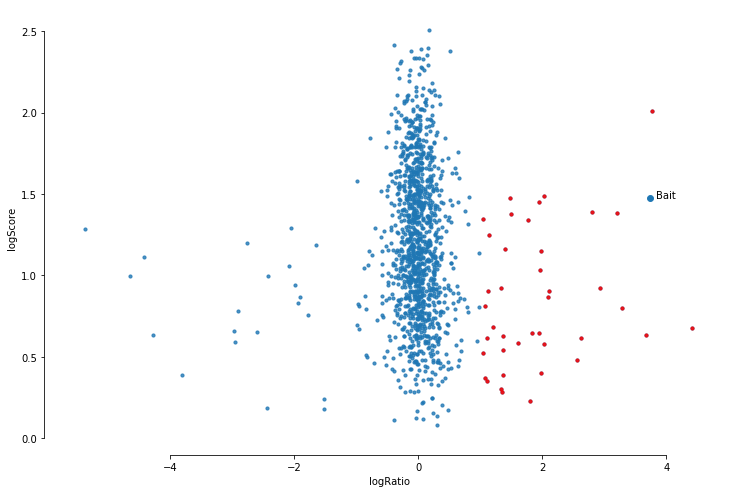

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='logRatio', y='logScore', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)


sns.regplot(x='logRatio', y='logScore', 
            fit_reg=False, data = selection[selection['logRatio']>1],
            ax=ax, scatter_kws={'s':10,'color':'red'})
sns.despine(offset=10, trim=True)



x_val = selection.loc['Tb927.11.12080']['logRatio']
y_val = selection.loc['Tb927.11.12080']['logScore']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )
plt.savefig('test_fig.svg')
plt.show()


## Make interactive Figure

In [159]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logRatio,
    y=selection.logInt,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.Score )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.Score), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logRatio.loc['Tb927.11.12080']],
    y=[selection.logInt.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='MA SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Analysis label free
## Pull Down Tb927.11.12080 (N-acetyl-D-glucosaminylphosphatidylinositol de-N-acetylase)

In [7]:
df_lf = pd.read_csv('label_free/txt/proteinGroups.txt',sep='\t')
df_lf = clean(df_lf)
df_lf['Gene_id'] = [clean_id(n.split(';')[0]) for n in df_lf['Protein IDs']]
df_lf['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df_lf['Gene_id']]
df_lf.set_index('Gene_id',inplace=True)
df_lf=df_lf.join(ref_df,how='left')


tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)


df_lf = df_lf.join(tm, how='left')
df_lf['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df_lf['[SignalP Peptide]'] ] 


removed  33 Only identified by site
tot  33  entries removed
---------------
removed  12 Reverse
tot  45  entries removed
---------------
removed  36 Potential contaminant
tot  81  entries removed
---------------


In [8]:
df_lf.head()

Protein IDs  \
Gene_id                                                            
Tb927.5.4560   Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...   
Tb927.7.2140           Tb927.7.2140:mRNA-p1;Tb07.11L3.90:mRNA-p1   
Tb11.v5.0767   Tb11.v5.0767.1-p1;Tb927.10.4430:mRNA-p1;Tb10.v...   
Tb927.10.4450  Tb927.10.4450:mRNA-p1;Tb11.v5.0757.1-p1;Tb10.v...   
Tb927.10.4460         Tb927.10.4460:mRNA-p1;Tb10.v4.0036:mRNA-p1   

                                            Majority protein IDs  \
Gene_id                                                            
Tb927.5.4560   Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...   
Tb927.7.2140           Tb927.7.2140:mRNA-p1;Tb07.11L3.90:mRNA-p1   
Tb11.v5.0767   Tb11.v5.0767.1-p1;Tb927.10.4430:mRNA-p1;Tb10.v...   
Tb927.10.4450  Tb927.10.4450:mRNA-p1;Tb11.v5.0757.1-p1;Tb10.v...   
Tb927.10.4460         Tb927.10.4460:mRNA-p1;Tb10.v4.0036:mRNA-p1   

              Peptide counts (all) Peptide counts (razor+unique)  \
Gene_id                                                            
Tb927.5.4560                 4;4;4                         4;4;4   
Tb927.7.2140                   6;6                           6;6   
Tb11.v5.0767                 2;2;2                         2;2;2   
Tb927.10.4450                4;4;4                         4;4;4   
Tb927.10.4460                  1;1                           1;1   

              Peptide counts (unique) Fasta headers  Number of proteins  \
Gene_id                                                                   
Tb927.5.4560                    4;4;4            ;;                   3   
Tb927.7.2140                      6;6             ;                   2   
Tb11.v5.0767                    2;2;2            ;;                   3   
Tb927.10.4450                   4;4;4            ;;                   3   
Tb927.10.4460                     1;1             ;                   2   

               Peptides  Razor + unique peptides  Unique peptides     ...      \
Gene_id                                                               ...       
Tb927.5.4560          4                        4                4     ...       
Tb927.7.2140          6                        6                6     ...       
Tb11.v5.0767          2                        2                2     ...       
Tb927.10.4450         4                        4                4     ...       
Tb927.10.4460         1                        1                1     ...       

               Group  Glycosome status       [Gene ID]         [source_id]  \
Gene_id                                                                      
Tb927.5.4560     NaN                NaN   Tb927.5.4560   Tb927.5.4560:mRNA   
Tb927.7.2140       i                red   Tb927.7.2140   Tb927.7.2140:mRNA   
Tb11.v5.0767     NaN                NaN   Tb11.v5.0767      Tb11.v5.0767.1   
Tb927.10.4450    NaN                NaN  Tb927.10.4450  Tb927.10.4450:mRNA   
Tb927.10.4460      i                red  Tb927.10.4460  Tb927.10.4460:mRNA   

                               [Genomic Location (Gene)]  \
Gene_id                                                    
Tb927.5.4560       Tb927_05_v5.1:1,410,659..1,413,260(+)   
Tb927.7.2140           Tb927_07_v5.1:545,293..550,039(-)   
Tb11.v5.0767   Tb927_11_bin_v5.1:4,003,068..4,009,929(+)   
Tb927.10.4450      Tb927_10_v5.1:1,144,964..1,146,072(-)   
Tb927.10.4460      Tb927_10_v5.1:1,146,333..1,147,303(-)   

                                      [Product Description]  [# TM Domains]  \
Gene_id                                                                       
Tb927.5.4560                    guanine deaminase, putative               0   
Tb927.7.2140    zinc finger protein family member, putative               0   
Tb11.v5.0767     pumillo RNA binding protein PUF1, putative               0   
Tb927.10.4450  stress-inducible protein STI1-like, putative               0   
Tb927.10.4460  leucine carboxyl methyltransferase, putative               0   

      

In [9]:
df_lf['iBAQ DM-dig'].nsmallest(3)

Gene_id
Tb927.10.4460    0.0
Tb927.7.4670     0.0
Tb927.7.4720     0.0
Name: iBAQ DM-dig, dtype: float64

In [10]:
# Using ms/ms count as proxy of aboundance
df_lf['log2_ms_dig'] = np.log2((df_lf['MS/MS count TbGPI12-dig']+1)/(df_lf['MS/MS count DM-dig']+1))
df_lf['log2_ms_tx'] = np.log2((df_lf['MS/MS count TbGPI12-tx']+1)/(df_lf['MS/MS count DM-tx']+1))
                                      
df_lf['log2_ibaq_dig'] = np.log2(
    (df_lf['iBAQ TbGPI12-dig']+df_lf['iBAQ DM-dig'][df_lf['iBAQ DM-dig']>0].min())/(df_lf['iBAQ DM-dig']+df_lf['iBAQ DM-dig'][df_lf['iBAQ DM-dig']>0].min()))

df_lf['log2_ibaq_tx'] = np.log2(
    (df_lf['iBAQ TbGPI12-tx']+df_lf['iBAQ DM-tx'][df_lf['iBAQ DM-tx']>0].min() ) / (df_lf['iBAQ DM-tx']+df_lf['iBAQ DM-tx'][df_lf['iBAQ DM-tx']>0].min()))

df_lf['log2_int_dig'] = np.log2(
    (df_lf['Intensity TbGPI12-dig']+df_lf['Intensity DM-dig'][df_lf['Intensity DM-dig']>0].min())/(df_lf['Intensity DM-dig']+df_lf['Intensity DM-dig'][df_lf['Intensity DM-dig']>0].min()))

df_lf['log2_int_tx'] = np.log2(
    (df_lf['Intensity TbGPI12-tx']+df_lf['Intensity DM-tx'][df_lf['Intensity DM-tx']>0].min() ) / (df_lf['Intensity DM-tx']+df_lf['Intensity DM-tx'][df_lf['Intensity DM-tx']>0].min()))

df_lf['log10_int_dig']=np.log10(df_lf['Intensity DM-dig']+df_lf['Intensity TbGPI12-dig'])                                                       
df_lf['log10_int_tx'] = np.log10(df_lf['Intensity DM-tx']+df_lf['Intensity TbGPI12-tx'])
                                       
df_lf.to_csv('label_free/txt/proteinGroups_clean.csv')
df_lf.head()

Protein IDs  \
Gene_id                                                            
Tb927.5.4560   Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...   
Tb927.7.2140           Tb927.7.2140:mRNA-p1;Tb07.11L3.90:mRNA-p1   
Tb11.v5.0767   Tb11.v5.0767.1-p1;Tb927.10.4430:mRNA-p1;Tb10.v...   
Tb927.10.4450  Tb927.10.4450:mRNA-p1;Tb11.v5.0757.1-p1;Tb10.v...   
Tb927.10.4460         Tb927.10.4460:mRNA-p1;Tb10.v4.0036:mRNA-p1   

                                            Majority protein IDs  \
Gene_id                                                            
Tb927.5.4560   Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...   
Tb927.7.2140           Tb927.7.2140:mRNA-p1;Tb07.11L3.90:mRNA-p1   
Tb11.v5.0767   Tb11.v5.0767.1-p1;Tb927.10.4430:mRNA-p1;Tb10.v...   
Tb927.10.4450  Tb927.10.4450:mRNA-p1;Tb11.v5.0757.1-p1;Tb10.v...   
Tb927.10.4460         Tb927.10.4460:mRNA-p1;Tb10.v4.0036:mRNA-p1   

              Peptide counts (all) Peptide counts (razor+unique)  \
Gene_id                                                            
Tb927.5.4560                 4;4;4                         4;4;4   
Tb927.7.2140                   6;6                           6;6   
Tb11.v5.0767                 2;2;2                         2;2;2   
Tb927.10.4450                4;4;4                         4;4;4   
Tb927.10.4460                  1;1                           1;1   

              Peptide counts (unique) Fasta headers  Number of proteins  \
Gene_id                                                                   
Tb927.5.4560                    4;4;4            ;;                   3   
Tb927.7.2140                      6;6             ;                   2   
Tb11.v5.0767                    2;2;2            ;;                   3   
Tb927.10.4450                   4;4;4            ;;                   3   
Tb927.10.4460                     1;1             ;                   2   

               Peptides  Razor + unique peptides  Unique peptides  \
Gene_id                                                             
Tb927.5.4560          4                        4                4   
Tb927.7.2140          6                        6                6   
Tb11.v5.0767          2                        2                2   
Tb927.10.4450         4                        4                4   
Tb927.10.4460         1                        1                1   

                   ...       [SignalP Scores]  Unnamed: 8  log2_ms_dig  \
Gene_id            ...                                                   
Tb927.5.4560       ...                    NaN         NaN    -2.000000   
Tb927.7.2140       ...                    NaN         NaN    -1.584963   
Tb11.v5.0767       ...                    NaN         NaN    -1.584963   
Tb927.10.4450      ...                    NaN         NaN    -1.807355   
Tb927.10.4460      ...                    NaN         NaN     0.000000   

               log2_ms_tx  log2_ibaq_dig  log2_ibaq_tx  log2_int_dig  \
Gene_id                                                                
Tb927.5.4560     1.000000      -5.365376      1.716002     -5.197062   
Tb927.7.2140     1.584963      -4.767255      3.595867     -4.610216   
Tb11.v5.0767     0.000000      -5.312055      0.000000     -4.868916   
Tb927.10.4450    0.000000      -2.868916      0.000000     -2.672664   
Tb927.10.4460   -1.584963       0.000000     -2.392954      0.000000   

               log2_int_tx  log10_int_dig  log10_int_tx  
Gene_id                                                  
Tb927.5.4560      1.474023       5.744840      4.566331  
Tb927.7.2140      2.232147       6.354337      4.884416  
Tb11.v5.0767      0.000000       5.642939          -inf  
Tb927.10.4450     0.000000       5.482599          -inf  
Tb927.10.4460    -1.644722           -inf      4.644153  

[5 rows x 99 columns]

## Plot Digitonine

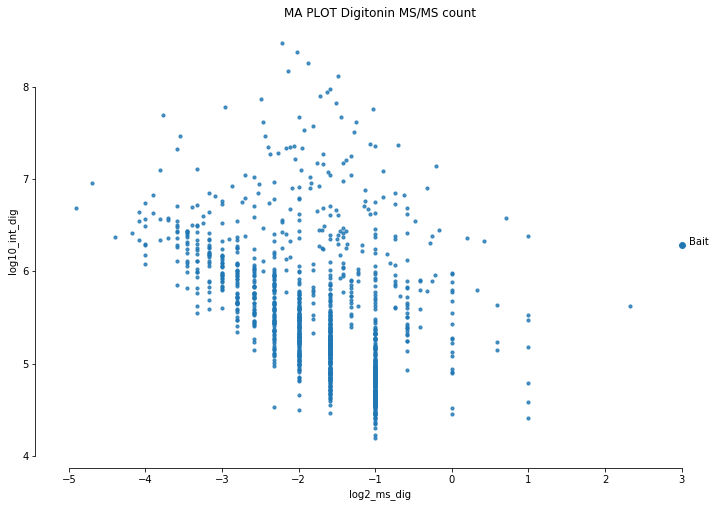

In [124]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ms_dig', y='log10_int_dig', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_ms_dig']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_dig']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )
plt.title('MA PLOT Digitonin MS/MS count')
plt.show()

In [128]:
#interactive plot
temp = df_lf[df_lf['Score'] > 0]
trace_1 = go.Scatter(
    x=temp.log2_ms_dig,
    y=temp.log10_int_dig,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = temp.log2_ms_dig, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_ms_dig.loc['Tb927.11.12080']],
    y=[temp.log10_int_dig.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

layout = dict(title='MA PLOT Digitonin MS/MS count')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

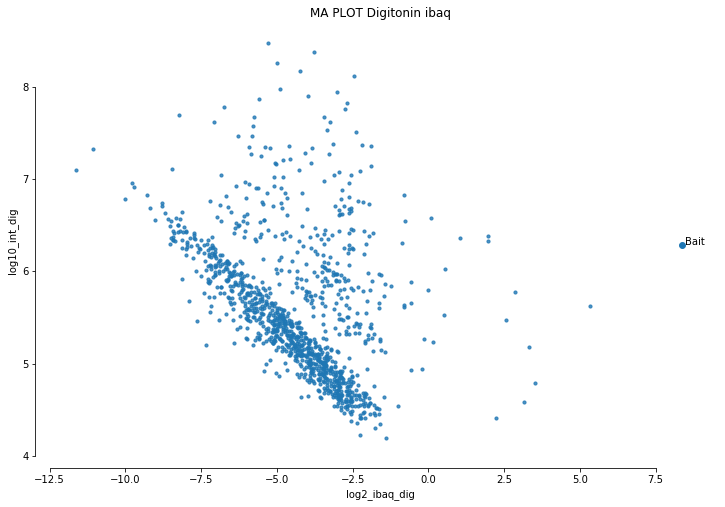

In [125]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ibaq_dig', y='log10_int_dig', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_ibaq_dig']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_dig']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )
plt.title('MA PLOT Digitonin ibaq')
plt.show()

In [165]:
#interactive plot
temp = df_lf[df_lf['Score'] > 0]
#temp = df_lf[df_lf['Score'] > 0]
#temp = df_lf[df_lf['Score'] > 0]
#[SignalP Peptide]	[# TM Domains]

trace_1 = go.Scatter(
    x=temp.log2_ibaq_dig,
    y=temp.log10_int_dig,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b + ' '+ str(round(c,1)) for a,b,c in zip(temp.index.values, temp.Gene_desc, temp.Score)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(temp.Score), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_ibaq_dig.loc['Tb927.11.12080']],
    y=[temp.log10_int_dig.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

layout = dict(title='MA PLOT Digitonin iBAQ')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

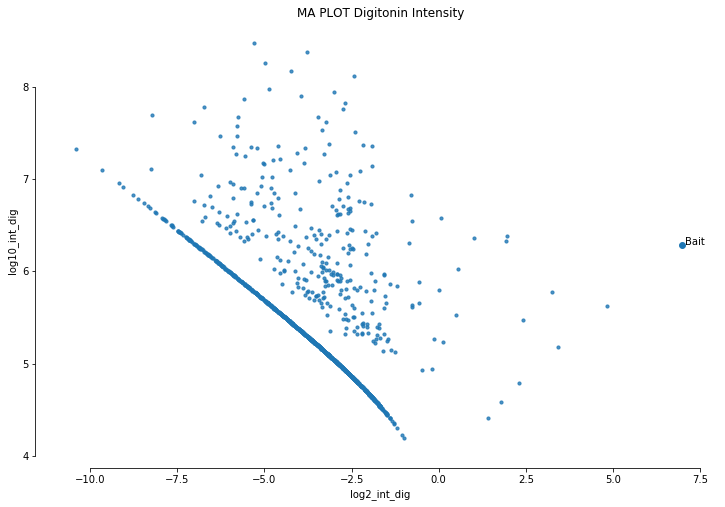

In [126]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_int_dig', y='log10_int_dig', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_int_dig']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_dig']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )
plt.title('MA PLOT Digitonin Intensity')
plt.show()

In [130]:
#interactive plot
temp = df_lf[df_lf['Score'] > 0]
trace_1 = go.Scatter(
    x=temp.log2_int_dig,
    y=temp.log10_int_dig,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = temp.log2_int_dig, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_int_dig.loc['Tb927.11.12080']],
    y=[temp.log10_int_dig.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

layout = dict(title='MA PLOT Digitonin Intensity')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

## PLOT Triton X-100

Text(3.68496,6.06423,'Bait')

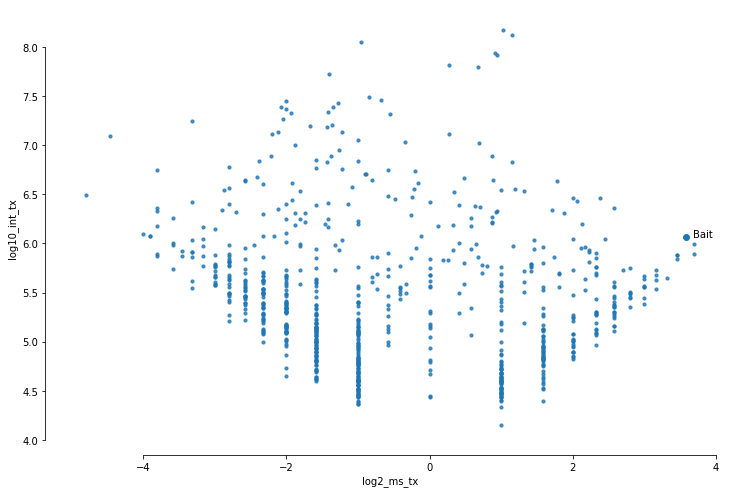

In [131]:

fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ms_tx', y='log10_int_tx', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_ms_tx']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_tx']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )


In [136]:
#interactive plot
temp = df_lf[df_lf['Score'] > 0]
trace_1 = go.Scatter(
    x=temp.log2_ms_tx,
    y=temp.log10_int_tx,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = temp.log2_ms_tx, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_ms_tx.loc['Tb927.11.12080']],
    y=[temp.log10_int_tx.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

layout = dict(title='MA PLOT Triton X-100 MS/MS count')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

Text(7.49917,6.06423,'Bait')

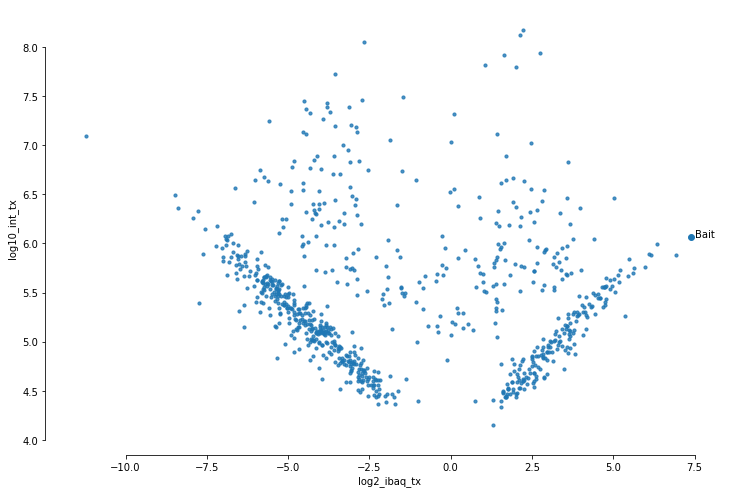

In [138]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ibaq_tx', y='log10_int_tx', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_ibaq_tx']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_tx']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )

In [153]:
#interactive plot
temp = df_lf[df_lf['Score'] > 0]
trace_1 = go.Scatter(
    x=temp.log2_ibaq_tx,
    y=temp.log10_int_tx,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(temp.index.values, temp.Gene_desc, temp.Score)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(temp.Score), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_ibaq_tx.loc['Tb927.11.12080']],
    y=[temp.log10_int_tx.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

layout = dict(title='MA PLOT Triton X-100 iBAQ')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

Text(5.9317,6.06423,'Bait')

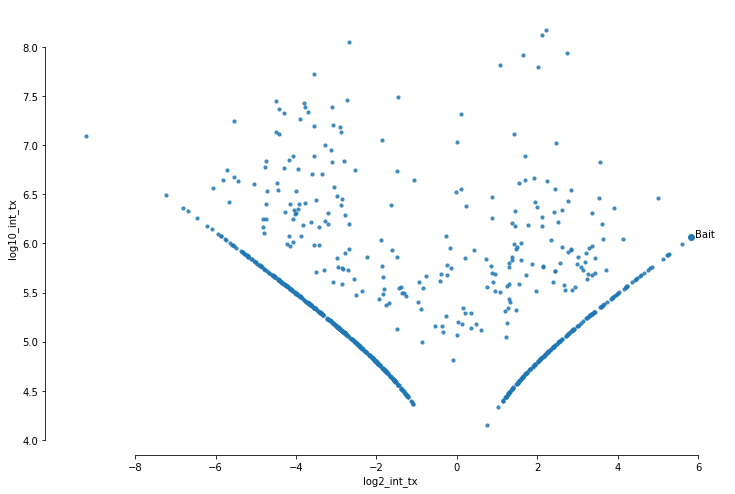

In [139]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_int_tx', y='log10_int_tx', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_int_tx']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_tx']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )

In [132]:
#interactive plot
temp = df_lf[df_lf['Score'] > 0]
trace_1 = go.Scatter(
    x=temp.log2_int_tx,
    y=temp.log10_int_tx,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = temp.log2_int_tx, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_int_tx.loc['Tb927.11.12080']],
    y=[temp.log10_int_tx.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

layout = dict(title='MA PLOT Triton X-100 Intensity')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Second Label Free

In [105]:
#df_lf2 = pd.read_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups.txt',sep='\t')
#df_lf2['gene_desc']=[desc_dict[clean_id(n)] if clean_id(n) in desc_dict else 'none' for n in df_lf2['Protein IDs']]
#df_lf2.tail()
#df_lf2.to_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups_desc.txt',sep='\t', index=False)

In [196]:
df_lf2 = pd.read_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups.txt',sep='\t')
df_lf2 = clean(df_lf2)
df_lf2['Gene_id'] = [clean_id(n.split(';')[0]) for n in df_lf2['Protein IDs']]
df_lf2['Gene_id'].to_csv('20180820 TbdeAc2 labeel free data-1/ids.txt')
df_lf2['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df_lf2['Gene_id']]
df_lf2.set_index('Gene_id',inplace=True)
df_lf2=df_lf2.join(ref_df,how='left')


df_lf2['log2_DEAC2'] = np.log2((df_lf2['MS/MS count DEAC2']+1)/(df_lf2['MS/MS count SM']+1))

df_lf2['log2_ibaq_DEAC2'] = np.log2(
    (df_lf2['iBAQ DEAC2']+df_lf2['iBAQ SM'][df_lf2['iBAQ SM']>0].min())/(df_lf2['iBAQ SM']+df_lf2['iBAQ SM'][df_lf2['iBAQ SM']>0].min())
)

df_lf2['log2_int_DEAC2'] = np.log2(
    (df_lf2['Intensity DEAC2']+df_lf2['Intensity SM'][df_lf2['Intensity SM']>0].min())/(df_lf2['Intensity SM']+df_lf2['Intensity SM'][df_lf2['Intensity SM']>0].min())
)

df_lf2['log10_int']=np.log10(df_lf2['Intensity DEAC2']+df_lf2['Intensity SM'])   


#tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
#tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
#tm.set_index('[Input ID]',inplace=True)


#df_lf2 = df_lf.join(tm, how='left')
#df_lf2['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df_lf2['[SignalP Peptide]'] ] 


df_lf2.to_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups_clean.csv')


df_lf2.head()

removed  23 Only identified by site
tot  23  entries removed
---------------
removed  21 Reverse
tot  44  entries removed
---------------
removed  42 Potential contaminant
tot  86  entries removed
---------------


Protein IDs  \
Gene_id                                                           
Tb927.5.4460  Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...   
Tb927.5.4480          Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1   
Tb927.5.4500          Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1   
Tb927.5.4360           Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1   
Tb927.5.4560  Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...   

                                           Majority protein IDs  \
Gene_id                                                           
Tb927.5.4460  Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...   
Tb927.5.4480          Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1   
Tb927.5.4500          Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1   
Tb927.5.4360           Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1   
Tb927.5.4560  Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...   

             Peptide counts (all) Peptide counts (razor+unique)  \
Gene_id                                                           
Tb927.5.4460             30;30;15                      30;30;15   
Tb927.5.4480                  1;1                           1;1   
Tb927.5.4500                  7;7                           7;7   
Tb927.5.4360                  1;1                           1;1   
Tb927.5.4560             10;10;10                      10;10;10   

             Peptide counts (unique) Fasta headers  Number of proteins  \
Gene_id                                                                  
Tb927.5.4460                30;30;15            ;;                   3   
Tb927.5.4480                     1;1             ;                   2   
Tb927.5.4500                     7;7             ;                   2   
Tb927.5.4360                     1;1             ;                   2   
Tb927.5.4560                10;10;10            ;;                   3   

              Peptides  Razor + unique peptides  Unique peptides    ...      \
Gene_id                                                             ...       
Tb927.5.4460        30                       30               30    ...       
Tb927.5.4480         1                        1                1    ...       
Tb927.5.4500         7                        7                7    ...       
Tb927.5.4360         1                        1                1    ...       
Tb927.5.4560        10                       10               10    ...       

              Oxidation (M) site positions  \
Gene_id                                      
Tb927.5.4460               251;405;481;797   
Tb927.5.4480                           NaN   
Tb927.5.4500                           112   
Tb927.5.4360                           NaN   
Tb927.5.4560                           NaN   

                                               Gene_desc  Log2 H/L  \
Gene_id                                                              
Tb927.5.4460               major vault protein, putative  0.263531   
Tb927.5.4480  paraflagellar rod component par4, putative  0.035299   
Tb927.5.4500             ras-like small GTPase, putative  0.429018   
Tb927.5.4360             hypothetical protein, conserved       NaN   
Tb927.5.4560                 guanine deaminase, putative       NaN   

              Log10 (Int H*L)  Group  Glycosome status   log2_DEAC2  \
Gene_id                                                               
Tb927.5.4460        14.050605      i                red    1.530515   
Tb927.5.4480        14.193449      i                red    1.000000   
Tb927.5.4500        16.998218      i                red   -0.263034   
Tb927.5.4360              NaN    NaN                NaN    1.000000   
Tb927.5.4560              NaN    NaN                NaN   -0.415037   

              log2_ibaq_DEAC2  log2_int_DEAC2  log10_int  
Gene_id                                                   
Tb927.5.4460         0.995926        0.995760   7.480007  
Tb927.5.4480         2.112410        1.484187   4.602841  
Tb927.5.4500         

Text(4.80044,6.98928,'Bait')

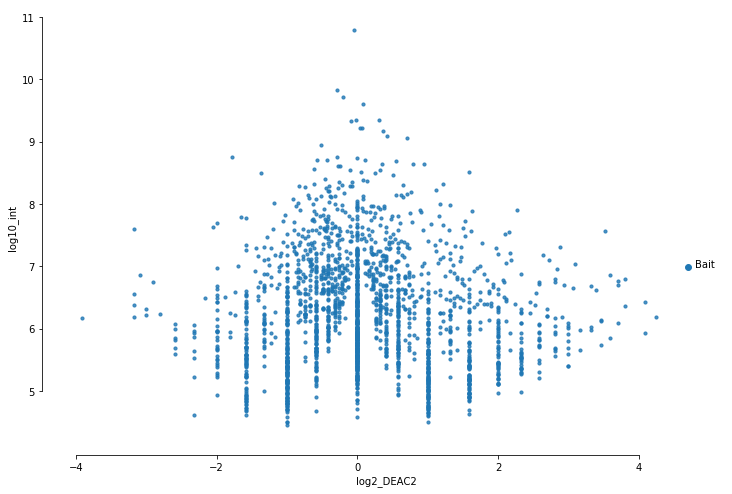

In [112]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_DEAC2', y='log10_int', 
            fit_reg=False, data = df_lf2,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf2.loc['Tb927.3.2610']['log2_DEAC2']
y_val = df_lf2.loc['Tb927.3.2610']['log10_int']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )

In [141]:
temp = df_lf2[df_lf2['Score']>0]
#interactive plot
trace_1 = go.Scatter(
    x=temp.log2_DEAC2,
    y=temp.log10_int,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(df_lf2.index.values, df_lf2.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = temp.log2_DEAC2, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_DEAC2.loc['Tb927.3.2610']],
    y=[temp.log10_int.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)




layout = dict(title='MA DEAC2 MS/MS count')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

Text(9.63317,6.98928,'Bait')

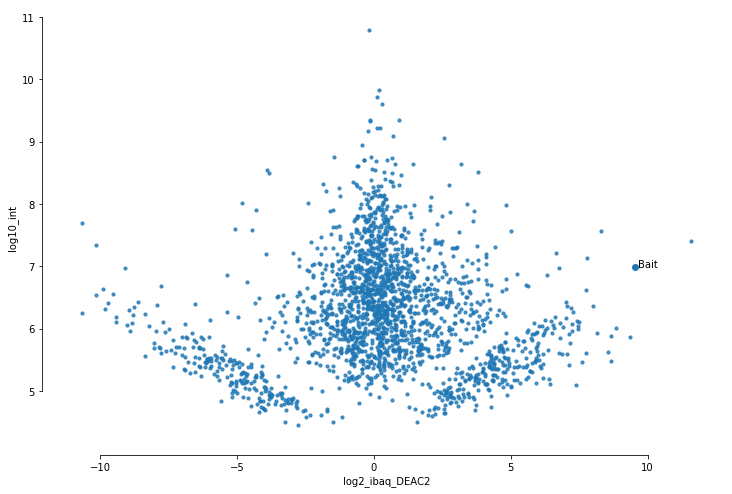

In [113]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ibaq_DEAC2', y='log10_int', 
            fit_reg=False, data = df_lf2,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf2.loc['Tb927.3.2610']['log2_ibaq_DEAC2']
y_val = df_lf2.loc['Tb927.3.2610']['log10_int']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )

In [172]:
temp = df_lf2[df_lf2['Score']>30]
temp = temp[ (temp['log2_ibaq_DEAC2']>2) & (temp['log2_ibaq_DEAC2']<10) ]
temp = temp[ (temp['log10_int']>6) & (temp['log10_int']<7.6)]
#interactive plot
trace_1 = go.Scatter(
    x=temp.log2_ibaq_DEAC2,
    y=temp.log10_int,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b+ ' '+str(round(c,1)) for a,b,c in zip(temp.index.values, temp.Gene_desc, temp.Score)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log(temp.Score), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_ibaq_DEAC2.loc['Tb927.3.2610']],
    y=[temp.log10_int.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)

annot_2 = go.Scatter(
    x=[temp.log2_ibaq_DEAC2.loc['Tb927.7.1220']],
    y=[temp.log10_int.loc['Tb927.7.1220']],
    mode='markers+text',
    name='Tb927.7.1220',
    text=['interesting'],
    textposition='bottom center'
)


layout = dict(title='MA DEAC2 iBAQ')

fig = go.Figure(data=[trace_1, annot_1, annot_2], 
                layout=layout)
iplot(fig, filename='test')

Text(8.87694,6.98928,'Bait')

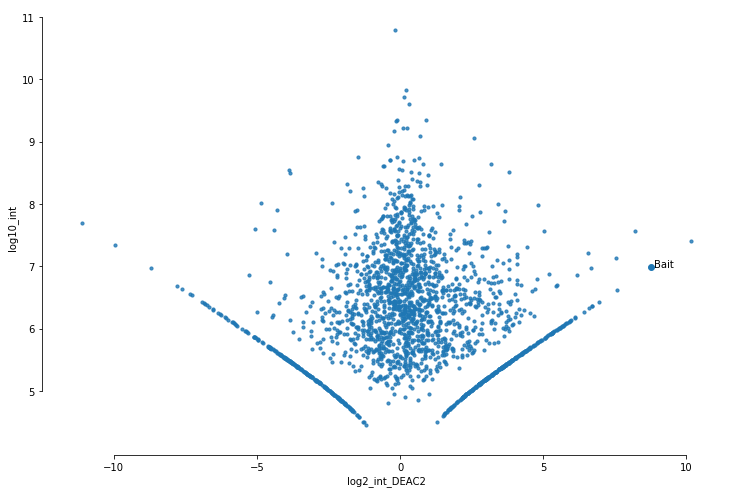

In [114]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_int_DEAC2', y='log10_int', 
            fit_reg=False, data = df_lf2,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf2.loc['Tb927.3.2610']['log2_int_DEAC2']
y_val = df_lf2.loc['Tb927.3.2610']['log10_int']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )

In [144]:
temp = df_lf2[df_lf2['Score']>0]
#interactive plot
trace_1 = go.Scatter(
    x=temp.log2_int_DEAC2,
    y=temp.log10_int,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = temp.log2_int_DEAC2, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[temp.log2_int_DEAC2.loc['Tb927.3.2610']],
    y=[temp.log10_int.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)




layout = dict(title='MA DEAC2 Intensity')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Make Interactive PLOT

In [39]:
'''
upep_from_col = set(selection['unique'])
upep_ints = sorted(list(upep_from_col))
upeps = [str(up) for up in upep_ints]


# make list of continents
tm_domains = list(set(selection['[# TM Domains]']))

columns = []
# make grid
for up in upeps:
    for tm in tm_domains:
        dataset_by_year = selection[selection['unique'] == int(up)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['[# TM Domains]'] == tm]
        for col_name in dataset_by_year_and_cont:
            #print (col_name)
            # each column name is unique
            column_name = '{unique_pep}_{tm}_{header}_gapminder_grid'.format(
                unique_pep=up, tm=tm, header=col_name
            )
            a_column = Column(list(dataset_by_year_and_cont[col_name]), column_name)
            columns.append(a_column)

# upload grid
grid = Grid(columns)

figure = {
    'data': [],
    'layout': {},
    'frames': [],
    'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['xaxis'] = {'logRatio': 'logRatio', 'title': 'Log 2 Fold change', 'gridcolor': '#FFFFFF'}
figure['layout']['yaxis'] = {'title': 'GDP per Capita', 'type': 'log', 'gridcolor': '#FFFFFF'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['plot_bgcolor'] = 'rgb(223, 232, 243)'
'''

In [178]:
def parse_phobius(in_file='phobius_prediction.txt'):
    res_prot = []
    res_counts = []
    count = 0
    for l in open(in_file):
        if l.startswith('ID'):
            res_prot.append(l.split()[-1].strip())
        if 'TRANSMEM' in l:
            count+=1
        if l.startswith('//'):
            res_counts.append(count)
            count=0
    return res_prot,res_counts
        
res_prot,res_counts=parse_phobius(in_file='20180820 TbdeAc2 labeel free data-1/phobius_prediction.txt') 
print (len(res_prot),len(res_counts))
tm_count_dict = dict(zip(res_prot,res_counts))
print (tm_count_dict['Tb927.3.2610'])

11567 11567
11


In [189]:
phobius_df = pd.DataFrame()
phobius_df['Gene_ids']=res_prot
phobius_df['TM count']=res_counts
phobius_df.set_index('Gene_ids',inplace=True)
phobius_df.head()

TM count
Gene_ids              
Tb927.7.4160         7
Tb927.4.1150         0
Tb927.3.1130         0
Tb927.2.2500         2
Tb927.3.2430         1

In [179]:
import re
motif_list = [ 'G.S.G', 'G.SGS', 'GDSL', 'GDSA', 'HD..Y', 'Y.G.G', 'HD', 'HE']
motif_list = [re.compile(n) for  n in motif_list]

[re.compile(r'G.S.G', re.UNICODE),
 re.compile(r'G.SGS', re.UNICODE),
 re.compile(r'GDSL', re.UNICODE),
 re.compile(r'GDSA', re.UNICODE),
 re.compile(r'HD..Y', re.UNICODE),
 re.compile(r'Y.G.G', re.UNICODE),
 re.compile(r'HD', re.UNICODE),
 re.compile(r'HE', re.UNICODE)]

In [182]:
#add back the description of the proteins
motif_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        temp_res = []
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_seq = str(record.seq)
        for item in motif_list:
            temp_res.append(len(item.findall(temp_seq)))
        motif_dict[temp_id]=temp_res        

In [183]:
motif_dict['Tb927.7.1220']

[2, 0, 0, 0, 0, 1, 0, 1]

In [186]:
motif_dict_df = pd.DataFrame(motif_dict).T
motif_dict_df.columns = ['G.S.G', 'G.SGS', 'GDSL', 'GDSA', 'HD..Y', 'Y.G.G', 'HD', 'HE']
motif_dict_df.head()

G.S.G  G.SGS  GDSL  GDSA  HD..Y  Y.G.G  HD  HE
Tb427.BES40.22      0      0     0     0      0      0   1   1
Tb927.1.05          0      0     0     0      0      0   1   0
Tb927.1.1000        0      0     0     0      0      0   0   0
Tb927.1.100         0      0     0     0      0      0   0   2
Tb927.1.1010        0      0     0     0      0      0   0   0

In [264]:
def parse_cdd(in_file=''):
    res = {}
    a=0
    for l in open(in_file):
        #print (l.split('\t'))
        prot = l.split('\t')[0].split('>')[1].split('|')[0].strip()
        #print (prot)
        #domain =  l.split()[-3]
        score = ' ' .join(l.split()[-7:])
        if prot in res:
            res[prot]+=[score]
        else:
            res[prot]=[score]
       # a+=1
        #if a > 10:
            #break
    return res
    
res_cdd = parse_cdd('20180820 TbdeAc2 labeel free data-1/zhe_hitdata.txt')
print (res_cdd['Tb927.10.13720'])

['79 9.15395e-17 73.8785 cd00590 RRM_SF - cl17169', '2.59044e-08 55.1982 cl25887 RRM superfamily N -', '0.0041206 37.931 cl25749 DUF959 superfamily NC -']


In [ ]:
df_lf2=df_lf2.join(motif_dict_df, how='left')
df_lf2=df_lf2.join(phobius_df, how='left')

In [265]:
df_lf2['domain']=[' | '.join(res_cdd[n]) if n in  res_cdd else 'none' for n in df_lf2.index.values]

In [271]:
df_lf2.head()
df_lf2.to_csv('20180820 TbdeAc2 labeel free data-1/zhe_perseus_clean.csv')

In [5]:
mike_selection ='''Tb927.11.11480
Tb927.8.1090
Tb927.3.5040
Tb927.7.1220
Tb927.7.7320
Tb927.1.1500
Tb927.8.1210
Tb927.3.4120
Tb927.7.5290
Tb927.11.11720
Tb927.2.2530
Tb927.10.14740
Tb927.6.2380
Tb927.11.7690
Tb927.4.2890
Tb927.8.8150
Tb927.7.5450
Tb927.4.2850
'''.split()

In [268]:
mike_selection  = df_lf2.loc[mike_selection]
mike_selection = mike_selection[['log2_ibaq_DEAC2',
                                 'log10_int', 
                                 'Gene_desc',
                                 'TM count',
                                 'G.S.G',
                                 'G.SGS', 
                                 'GDSL', 
                                 'GDSA', 
                                 'HD..Y', 
                                 'Y.G.G', 
                                 'HD', 'HE','domain']]
mike_selection.head(50)

log2_ibaq_DEAC2  log10_int  \
Gene_id                                      
Tb927.11.11480         7.440205   6.043716   
Tb927.8.1090           7.193574   6.329601   
Tb927.3.5040           7.028154   6.179753   
Tb927.7.1220           7.026275   6.435988   
Tb927.7.7320           6.900562   6.029871   
Tb927.1.1500           6.817643   6.086858   
Tb927.8.1210           6.778724   6.982322   
Tb927.3.4120           6.562921   6.009451   
Tb927.7.5290           6.311916   6.858916   
Tb927.11.11720         5.622074   6.691853   
Tb927.2.2530           4.811114   6.791307   
Tb927.10.14740         4.481674   6.220264   
Tb927.6.2380           4.279342   6.708094   
Tb927.11.7690          4.259935   6.110640   
Tb927.4.2890           4.246523   6.322600   
Tb927.8.8150           4.148073   6.560452   
Tb927.7.5450           4.141637   6.254674   
Tb927.4.2850           4.135590   6.717180   

                                             Gene_desc  TM count  G.S.G  \
Gene_id                                                                   
Tb927.11.11480                  Trichohyalin, putative       0.0      0   
Tb927.8.1090                                     NPAPL       0.0      1   
Tb927.3.5040           hypothetical protein, conserved       0.0      1   
Tb927.7.1220           hypothetical protein, conserved       0.0      2   
Tb927.7.7320           hypothetical protein, conserved       5.0      3   
Tb927.1.1500       conserved protein, unknown function       0.0      1   
Tb927.8.1210           hypothetical protein, conserved       0.0      0   
Tb927.3.4120           hypothetical protein, conserved       1.0      0   
Tb927.7.5290           hypothetical protein, conserved       0.0      1   
Tb927.11.11720         FG-GAP repeat protein, putative       1.0      0   
Tb927.2.2530           hypothetical protein, conserved       0.0      1   
Tb927.10.14740         hypothetical protein, conserved       2.0      0   
Tb927.6.2380           hypothetical protein, conserved       0.0      0   
Tb927.11.7690                     hypothetical protein       0.0      0   
Tb927.4.2890           hypothetical protein, conserved       0.0      0   
Tb927.8.8150    C2 domain containing protein, putative       0.0      0   
Tb927.7.5450                           lipin, putative       0.0      1   
Tb927.4.2850           hypothetical protein, conserved       0.0      2   

                G.SGS  GDSL  GDSA  HD..Y  Y.G.G  HD  HE  \
Gene_id                                                   
Tb927.11.11480      0     0     0      0      0   1   0   
Tb927.8.1090        0     0     0      0      1   0   0   
Tb927.3.5040        0     0     0      0      0   1   2   
Tb927.7.1220        0     0     0      0      1   0   1   
Tb927.7.7320        0     0     0      0      0   0   1   
Tb927.1.1500        0     0     0      0      1   0   3   
Tb927.8.1210        0     0     0      0      0   8   0   
Tb927.3.4120        0     0     0      0      0   1   2   
Tb927.7.5290        0     1     0      0      1   2   2   
Tb927.11.11720      0     0     0      0      0   0   1   
Tb927.2.2530        1     0     0      0      0   2   2   
Tb927.10.14740      0     0     0      0      0   1   1   
Tb927.6.2380        0     0     0      0      0   0   1   
Tb927.11.7690       0     0     0      0      0   1   1   
Tb927.4.2890        0     0     0      0      0   1   0   
Tb927.8.8150        0     0     0      0      0   1   0   
Tb927.7.5450        0     0     0      0      2   0   0   
Tb927.4.2850        0     0     0      0      0   0   2   

                                                           domain  
Gene_id                                                            
Tb927.11.11480  2.64928e-16 83.2667 cl26511 Neuromodulin_N sup...  
Tb927.8.1090    1.14378e-43 164.56 cl27230 PAP_assoc superfami...  
Tb927.3.5040                                                 none  
Tb927.7.1220    1.18238e-06 46.093 cl17238 RING_Ubox superfami...  
Tb927

In [270]:
mike_selection.to_csv('20180820 TbdeAc2 labeel free data-1/mike_selection.csv')